In [1]:
from numpy.random import seed
seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
from tensorflow.python.keras.callbacks import TensorBoard

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective_2D #, plot_histogram
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import datetime as dt

from sklearn.preprocessing import StandardScaler

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'fp', 'fn']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()

def multivariate_data(
    dataset,
    target, 
    start_index, 
    end_index, 
    history_size,
    target_size, 
    step
):
    
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

def log_dir_name(
    learning_rate,
    past_history,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda,
    class_0_weight,
    class_1_weight
):

    # The dir-name for the TensorBoard log-dir.
    s = "./LSTM_logs/past_history_{1}_hidden_layers_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(
        learning_rate,
        past_history,
        lstm_units,
        hidden_layers,
        hidden_units,
        #lstm_l2_lambda,
        hidden_l2_lambda,
        class_0_weight,
        class_1_weight
    )

    return log_dir

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * ((precision*10) * recall) / ((precision*10) + recall + K.epsilon())
    
    return f1_val

In [4]:
data_file = '../data/training_data/1992-2015_training_data_added_features.csv'

# Datatypes for dataframe loading
dtypes = {
    'lat': float,
    'lon': float,
    'weather_bin_year': int,
    'weather_bin_month': int,
    'weather_bin_day': int,
    'air.2m': float,
    'apcp': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'vis': float,
    'ignition': float,
    'mean.air.2m': float,
    'mean.apcp': float,
    'mean.rhum.2m': float,
    'mean.dpt.2m': float,
    'mean.pres.sfc': float,
    'mean.uwnd.10m': float,
    'mean.vwnd.10m': float,
    'mean.veg': float,
    'mean.vis': float,
    'max.air.2m': float,
    'max.apcp': float,
    'max.rhum.2m': float,
    'max.dpt.2m': float,
    'max.pres.sfc': float,
    'max.uwnd.10m': float,
    'max.vwnd.10m': float,
    'max.veg': float,
    'max.vis': float,
    'min.air.2m': float,
    'min.apcp': float,
    'min.rhum.2m': float,
    'min.dpt.2m': float,
    'min.pres.sfc': float,
    'min.uwnd.10m': float,
    'min.vwnd.10m': float,
    'min.veg': float,
    'min.vis': float,
    'total_fires': float

}

# Features to use during training 
features = [
    'lat',
    'lon',
    'weather_bin_month',
    'veg',
    'ignition',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.veg',
    'mean.vis',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

features_to_scale = [
    'veg',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

In [5]:
raw_data = pd.read_csv(data_file, index_col=0, parse_dates=True, dtype=dtypes)

In [6]:
# Pull out columns of intrest
data = raw_data[features]

In [7]:
# Pick one spatial bin with fires
data = data[(data['lat'] == 39.42233) & (data['lon'] == -120.6546)]

In [8]:
# Also drop lat, lon, day and year columns (unnecessary)
data.drop(['lat', 'lon'], axis=1, inplace=True)

In [9]:
# One hot encode month
column_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)

onehot_month_df['datetime'] = pd.to_datetime(data.index)
onehot_month_df = onehot_month_df.set_index('datetime')
data = pd.concat([data, onehot_month_df], axis=1)

In [10]:
# Scale data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

In [11]:
# Sort by date time index
# one_bin_training_data = one_bin_training_data.sort_index()
data = data.sort_index()

In [12]:
data.head()

,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,mean.vwnd.10m,mean.veg,...,March,April,May,June,July,August,Septermber,October,November,December
1992-01-01,0.503702,0.0,-1.138237,-0.368419,-0.485131,-1.694950,0.575796,-0.787113,0.389269,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-02,0.503702,0.0,-0.916780,-0.359414,-0.717171,-1.648949,-0.455567,-0.610320,-0.105418,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-03,0.503702,0.0,-1.003120,0.155398,0.521572,-0.763310,-1.945359,0.406430,0.978409,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-04,0.503702,0.0,-1.013071,1.580237,1.798763,0.130060,-2.642089,0.746722,2.634629,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-05,0.503702,0.0,-1.245384,0.645080,1.815982,-0.175384,-3.348068,0.378398,1.619435,70.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.1))
leftover_data = data.iloc[:-int(len(data)*0.1)]

validation_data = data.tail(int(len(leftover_data)*0.3))
training_data = data.iloc[:-int(len(leftover_data)*0.3)]

In [14]:
# Convert to numpy arrays
training_data = np.array(training_data)
validation_data = np.array(validation_data)
test_data = np.array(test_data)

In [15]:
future_target = 1
step = 1

initial_bias = -1.4
output_bias = tf.keras.initializers.Constant(initial_bias)

# weight_for_0 = 0.5 
# weight_for_1 = 13
# class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 15
BATCH_SIZE = 100
STEPS_PER_EPOCH = (len(training_data) * 0.25) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 0.25) // BATCH_SIZE

path_best_model = 'best_LTSM.keras'
best_fraction_incorrect = 1.0

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    f1
]

dim_learning_rate = Real(
    low=0.00001, 
    high=0.1, 
    prior='log-uniform',
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=30, 
    name='past_history'
)

dim_lstm_units = Integer(
    low=5, 
    high=500,
    name='lstm_units'
)

dim_hidden_layers = Integer(
    low=1, 
    high=10,
    name='hidden_layers'
)

dim_hidden_units = Integer(
    low=5, 
    high=500,
    name='hidden_units'
)

# dim_lstm_l2_lambda = Real(
#     low=0.0001, 
#     high=0.1,
#     prior='log-uniform',
#     name='lstm_l2_lambda'
# )

dim_hidden_l2_lambda = Real(
    low=0.0001, 
    high=0.1,
    prior='log-uniform',
    name='hidden_l2_lambda'
)

dim_class_0_weight = Real(
    low=0.1, 
    high=1,
    name='class_0_weight'
)

dim_class_1_weight = Integer(
    low=10, 
    high=20,
    name='class_1_weight'
)

default_parameters = [0.001, 3, 50, 2, 50, 0.1, 0.5, 15]

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_lstm_units,
    dim_hidden_layers,
    dim_hidden_units,
    #dim_lstm_l2_lambda,
    dim_hidden_l2_lambda,
    dim_class_0_weight,
    dim_class_1_weight
]

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [16]:
def make_model(
    input_dim,
    learning_rate,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda
):    
    input_shape = (100, input_dim[0], input_dim[1])

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape=input_shape,
#         bias_initializer=keras.initializers.VarianceScaling(
#             scale=1.0,
#             mode='fan_in', 
#             distribution='normal', 
#             seed=None
#         ),
#         kernel_regularizer=keras.regularizers.l2(lstm_l2_lambda),
#         activation = 'relu',
         stateful = True
    ))
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(
            hidden_units,
            bias_initializer=keras.initializers.VarianceScaling(
                scale=1.0,
                mode='fan_in', 
                distribution='normal', 
                seed=None
            ),
            kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
            activation = 'relu'
        ))

    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = learning_rate), 
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    lstm_units,
    hidden_layers,
    hidden_units,
    #lstm_l2_lambda,
    hidden_l2_lambda,
    class_0_weight,
    class_1_weight
):

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('past history:', past_history)
    print('LSTM units:', lstm_units)
    print('hidden layers:', hidden_layers)
    print('hidden units:', hidden_units)
    #print('lstm l2 lambda: {0:.1e}'.format(lstm_l2_lambda))
    print('hidden l2 lambda: {0:.1e}'.format(hidden_l2_lambda))
    print('class 0 weight:', class_0_weight)
    print('class 1 weight:', class_1_weight)
    print()
    
    # create data stream
    x_train, y_train = multivariate_data(
        training_data, 
        training_data[:, 1], 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = multivariate_data(
        validation_data, 
        validation_data[:, 1], 
        0,
        None,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % 100))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % 100))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    
    class_weight = {0: class_0_weight, 1: class_1_weight}
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_dim,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        hidden_layers = hidden_layers,
        hidden_units = hidden_units,
        #lstm_l2_lambda = lstm_l2_lambda,
        hidden_l2_lambda = hidden_l2_lambda,
    )
    
    model.summary()
    print()

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(
        learning_rate,
        past_history,
        lstm_units,
        hidden_layers,
        hidden_units,
        #lstm_l2_lambda,
        hidden_l2_lambda,
        class_0_weight,
        class_1_weight
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False
    )
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks = [early_stopping],
        validation_data=(x_validation, y_validation),
        validation_steps=VALIDATION_STEPS,
        class_weight=class_weight,
        workers=8
    )

    # Get fraction incorrect on the validation-set
    # after the last training-epoch.
          
    val_fp = history.history['val_fp'][-1]
    val_fn = history.history['val_fn'][-1]
    val_tp = history.history['val_tp'][-1]
    val_tn = history.history['val_tn'][-1]
          
    fraction_incorrect = (val_fn /(val_fn + val_tp + K.epsilon())) + (val_fp / (val_fp + val_tn + K.epsilon()))
    
    print()
    print("Validation fraction incorrect: {0:.2}".format(fraction_incorrect))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_fraction_incorrect

    # If the classification accuracy of the saved model is improved ...
    if fraction_incorrect < best_fraction_incorrect:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_fraction_incorrect = fraction_incorrect

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return fraction_incorrect

In [17]:
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=40,
    x0=default_parameters
)

learning rate: 1.0e-03
past history: 3
LSTM units: 50
hidden layers: 2
hidden units: 50
hidden l2 lambda: 1.0e-01
class 0 weight: 0.5
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 50)                 19800     
_________________________________________________________________
dense (Dense)                (100, 50)                 2550      
_________________________________________________________________
dense_1 (Dense)              (100, 50)                 2550      
_________________________________________________________________
dense_2 (Dense)              (100, 1)                  51        
Total params: 24,951
Trainable params: 24,951
Non-trainable params: 0
_________________________________________________________________

Train on 6300 samples, validate on 2300 samples
Epoch 1/15
1500/6300 [======>..................

1500/6300 [======>.......................] - ETA: 4s - loss: 0.8315 - tp: 37.0000 - fp: 481.0000 - tn: 964.0000 - fn: 18.0000 - accuracy: 0.6673 - precision: 0.0714 - recall: 0.6727 - auc: 0.7227 - f1: 0.5903 - val_loss: 0.1640 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 482.0000 - val_fn: 18.0000 - val_accuracy: 0.9640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7334 - val_f1: 0.0000e+00Epoch 00013: early stopping

Validation fraction incorrect: 0.5

learning rate: 3.7e-05
past history: 20
LSTM units: 33
hidden layers: 7
hidden units: 470
hidden l2 lambda: 1.0e-04
class 0 weight: 0.992990403362096
class 1 weight: 16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 33)                 10824     
_________________________________________________________________
dense (Dense)                (100, 470)                15980

1500/6300 [======>.......................] - ETA: 2s - loss: 1.2462 - tp: 50.0000 - fp: 459.0000 - tn: 967.0000 - fn: 24.0000 - accuracy: 0.6780 - precision: 0.0982 - recall: 0.6757 - auc: 0.7552 - f1: 0.7668 - val_loss: 0.2387 - val_tp: 11.0000 - val_fp: 182.0000 - val_tn: 301.0000 - val_fn: 6.0000 - val_accuracy: 0.6240 - val_precision: 0.0570 - val_recall: 0.6471 - val_auc: 0.7390 - val_f1: 0.3434
Validation fraction incorrect: 0.36

learning rate: 2.8e-03
past history: 1
LSTM units: 16
hidden layers: 6
hidden units: 203
hidden l2 lambda: 1.4e-04
class 0 weight: 0.9763799669573134
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 16)                 4160      
_________________________________________________________________
dense (Dense)                (100, 203)                3451      
_______________________________________

1500/6300 [======>.......................] - ETA: 0s - loss: 0.8326 - tp: 51.0000 - fp: 437.0000 - tn: 996.0000 - fn: 16.0000 - accuracy: 0.6980 - precision: 0.1045 - recall: 0.7612 - auc: 0.7851 - f1: 0.8644 - val_loss: 0.1638 - val_tp: 15.0000 - val_fp: 153.0000 - val_tn: 327.0000 - val_fn: 5.0000 - val_accuracy: 0.6840 - val_precision: 0.0893 - val_recall: 0.7500 - val_auc: 0.7510 - val_f1: 0.4625Epoch 00014: early stopping

Validation fraction incorrect: 0.28

learning rate: 2.3e-05
past history: 19
LSTM units: 194
hidden layers: 10
hidden units: 236
hidden l2 lambda: 3.8e-02
class 0 weight: 0.7122767847290018
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 194)                188568    
_________________________________________________________________
dense (Dense)                (100, 236)                46020     
________

1500/6300 [======>.......................] - ETA: 5s - loss: 79.1586 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1417.0000 - fn: 83.0000 - accuracy: 0.9447 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6574 - f1: 0.0000e+00 - val_loss: 17.0480 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 483.0000 - val_fn: 17.0000 - val_accuracy: 0.9660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7695 - val_f1: 0.0000e+00
Validation fraction incorrect: 0.5

learning rate: 1.1e-05
past history: 28
LSTM units: 284
hidden layers: 4
hidden units: 13
hidden l2 lambda: 4.9e-04
class 0 weight: 0.3169229194234106
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 284)                378288    
_________________________________________________________________
dense (Dense)                (100, 13)                 3705      
_

1500/6300 [======>.......................] - ETA: 13s - loss: 1.8219 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1422.0000 - fn: 78.0000 - accuracy: 0.9480 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6490 - f1: 0.0000e+00 - val_loss: 0.2350 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 485.0000 - val_fn: 15.0000 - val_accuracy: 0.9700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7128 - val_f1: 0.0000e+00
Validation fraction incorrect: 0.5

learning rate: 2.8e-03
past history: 25
LSTM units: 91
hidden layers: 5
hidden units: 95
hidden l2 lambda: 1.8e-02
class 0 weight: 0.48264028704212036
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 91)                 50960     
_________________________________________________________________
dense (Dense)                (100, 95)                 8740      
__

1500/6300 [======>.......................] - ETA: 3s - loss: 0.6132 - tp: 71.0000 - fp: 517.0000 - tn: 905.0000 - fn: 7.0000 - accuracy: 0.6507 - precision: 0.1207 - recall: 0.9103 - auc: 0.8038 - f1: 1.0131 - val_loss: 0.1099 - val_tp: 16.0000 - val_fp: 201.0000 - val_tn: 283.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5980 - val_precision: 0.0737 - val_recall: 1.0000 - val_auc: 0.7647 - val_f1: 0.5031
Validation fraction incorrect: 0.21

learning rate: 1.9e-03
past history: 2
LSTM units: 422
hidden layers: 5
hidden units: 201
hidden l2 lambda: 6.0e-02
class 0 weight: 0.7545447962707789
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 422)                795048    
_________________________________________________________________
dense (Dense)                (100, 201)                85023     
___________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.9150 - tp: 78.0000 - fp: 536.0000 - tn: 878.0000 - fn: 8.0000 - accuracy: 0.6373 - precision: 0.1270 - recall: 0.9070 - auc: 0.7805 - f1: 1.0413 - val_loss: 0.1815 - val_tp: 19.0000 - val_fp: 220.0000 - val_tn: 260.0000 - val_fn: 1.0000 - val_accuracy: 0.5580 - val_precision: 0.0795 - val_recall: 0.9500 - val_auc: 0.7460 - val_f1: 0.5235Epoch 00015: early stopping

Validation fraction incorrect: 0.25

learning rate: 1.9e-03
past history: 16
LSTM units: 481
hidden layers: 9
hidden units: 375
hidden l2 lambda: 4.2e-03
class 0 weight: 0.6280760490974635
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 481)                1019720   
_________________________________________________________________
dense (Dense)                (100, 375)                180750    
__________

1500/6300 [======>.......................] - ETA: 19s - loss: 1.1692 - tp: 74.0000 - fp: 589.0000 - tn: 825.0000 - fn: 12.0000 - accuracy: 0.5993 - precision: 0.1116 - recall: 0.8605 - auc: 0.7574 - f1: 0.8769 - val_loss: 0.1963 - val_tp: 16.0000 - val_fp: 197.0000 - val_tn: 286.0000 - val_fn: 1.0000 - val_accuracy: 0.6040 - val_precision: 0.0751 - val_recall: 0.9412 - val_auc: 0.7702 - val_f1: 0.4732
Validation fraction incorrect: 0.23

learning rate: 2.7e-03
past history: 9
LSTM units: 152
hidden layers: 2
hidden units: 13
hidden l2 lambda: 1.9e-03
class 0 weight: 0.45539336635801286
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 152)                122208    
_________________________________________________________________
dense (Dense)                (100, 13)                 1989      
_____________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.5835 - tp: 70.0000 - fp: 609.0000 - tn: 814.0000 - fn: 7.0000 - accuracy: 0.5893 - precision: 0.1031 - recall: 0.9091 - auc: 0.7900 - f1: 0.9362 - val_loss: 0.1127 - val_tp: 17.0000 - val_fp: 256.0000 - val_tn: 227.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4880 - val_precision: 0.0623 - val_recall: 1.0000 - val_auc: 0.7549 - val_f1: 0.4765
Validation fraction incorrect: 0.27

learning rate: 1.1e-05
past history: 7
LSTM units: 357
hidden layers: 8
hidden units: 305
hidden l2 lambda: 6.0e-02
class 0 weight: 0.6859693229517501
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 357)                579768    
_________________________________________________________________
dense (Dense)                (100, 305)                109190    
___________________________________

1500/6300 [======>.......................] - ETA: 4s - loss: 138.6771 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1420.0000 - fn: 80.0000 - accuracy: 0.9467 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6666 - f1: 0.0000e+00 - val_loss: 29.9978 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 483.0000 - val_fn: 17.0000 - val_accuracy: 0.9660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6915 - val_f1: 0.0000e+00
Validation fraction incorrect: 0.5

learning rate: 1.4e-04
past history: 22
LSTM units: 88
hidden layers: 4
hidden units: 439
hidden l2 lambda: 3.7e-04
class 0 weight: 0.864760333558409
class 1 weight: 14

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 88)                 48224     
_________________________________________________________________
dense (Dense)                (100, 439)                39071     
_

1500/6300 [======>.......................] - ETA: 3s - loss: 1.0847 - tp: 73.0000 - fp: 550.0000 - tn: 869.0000 - fn: 8.0000 - accuracy: 0.6280 - precision: 0.1172 - recall: 0.9012 - auc: 0.7932 - f1: 0.9751 - val_loss: 0.2054 - val_tp: 14.0000 - val_fp: 177.0000 - val_tn: 306.0000 - val_fn: 3.0000 - val_accuracy: 0.6400 - val_precision: 0.0733 - val_recall: 0.8235 - val_auc: 0.7562 - val_f1: 0.4140Epoch 00014: early stopping

Validation fraction incorrect: 0.27

learning rate: 4.0e-04
past history: 30
LSTM units: 166
hidden layers: 5
hidden units: 182
hidden l2 lambda: 4.0e-02
class 0 weight: 0.883674160935546
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 166)                142760    
_________________________________________________________________
dense (Dense)                (100, 182)                30394     
___________

1500/6300 [======>.......................] - ETA: 6s - loss: 5.2435 - tp: 65.0000 - fp: 554.0000 - tn: 867.0000 - fn: 14.0000 - accuracy: 0.6213 - precision: 0.1050 - recall: 0.8228 - auc: 0.7503 - f1: 0.8993 - val_loss: 1.0106 - val_tp: 13.0000 - val_fp: 208.0000 - val_tn: 278.0000 - val_fn: 1.0000 - val_accuracy: 0.5820 - val_precision: 0.0588 - val_recall: 0.9286 - val_auc: 0.7585 - val_f1: 0.4016
Validation fraction incorrect: 0.25

learning rate: 2.0e-03
past history: 30
LSTM units: 5
hidden layers: 3
hidden units: 196
hidden l2 lambda: 1.0e-01
class 0 weight: 1.0
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 196)                1176      
______________________________________________________

1500/6300 [======>.......................] - ETA: 1s - loss: 0.9448 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1424.0000 - fn: 76.0000 - accuracy: 0.9493 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4612 - f1: 0.0000e+00 - val_loss: 0.1527 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 486.0000 - val_fn: 14.0000 - val_accuracy: 0.9720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 0.5

learning rate: 2.9e-03
past history: 30
LSTM units: 181
hidden layers: 9
hidden units: 192
hidden l2 lambda: 1.1e-03
class 0 weight: 0.2761914780788377
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 181)                166520    
_________________________________________________________________
dense (Dense)                (100, 192) 

1500/6300 [======>.......................] - ETA: 9s - loss: 0.5468 - tp: 64.0000 - fp: 692.0000 - tn: 739.0000 - fn: 5.0000 - accuracy: 0.5353 - precision: 0.0847 - recall: 0.9275 - auc: 0.7875 - f1: 0.8597 - val_loss: 0.1119 - val_tp: 14.0000 - val_fp: 225.0000 - val_tn: 261.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5500 - val_precision: 0.0586 - val_recall: 1.0000 - val_auc: 0.7728 - val_f1: 0.4109Epoch 00014: early stopping

Validation fraction incorrect: 0.23

learning rate: 1.7e-03
past history: 30
LSTM units: 500
hidden layers: 7
hidden units: 127
hidden l2 lambda: 1.0e-04
class 0 weight: 0.4647020659301818
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 500)                1098000   
_________________________________________________________________
dense (Dense)                (100, 127)                63627     
______

1500/6300 [======>.......................] - ETA: 29s - loss: 0.7717 - tp: 71.0000 - fp: 638.0000 - tn: 783.0000 - fn: 8.0000 - accuracy: 0.5693 - precision: 0.1001 - recall: 0.8987 - auc: 0.7526 - f1: 0.9196 - val_loss: 0.1208 - val_tp: 14.0000 - val_fp: 260.0000 - val_tn: 226.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4800 - val_precision: 0.0511 - val_recall: 1.0000 - val_auc: 0.7848 - val_f1: 0.3972
Validation fraction incorrect: 0.27

learning rate: 4.8e-04
past history: 23
LSTM units: 100
hidden layers: 3
hidden units: 188
hidden l2 lambda: 5.4e-03
class 0 weight: 0.20895770075414954
class 1 weight: 18

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 100)                59600     
_________________________________________________________________
dense (Dense)                (100, 188)                18988     
________________________________

1500/6300 [======>.......................] - ETA: 3s - loss: 0.9539 - tp: 73.0000 - fp: 709.0000 - tn: 715.0000 - fn: 3.0000 - accuracy: 0.5253 - precision: 0.0934 - recall: 0.9605 - auc: 0.8063 - f1: 0.8773 - val_loss: 0.1912 - val_tp: 17.0000 - val_fp: 269.0000 - val_tn: 214.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4620 - val_precision: 0.0594 - val_recall: 1.0000 - val_auc: 0.7755 - val_f1: 0.4718Epoch 00014: early stopping

Validation fraction incorrect: 0.28

learning rate: 3.9e-04
past history: 6
LSTM units: 279
hidden layers: 4
hidden units: 107
hidden l2 lambda: 1.6e-02
class 0 weight: 0.9188179080377208
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 279)                366048    
_________________________________________________________________
dense (Dense)                (100, 107)                29960     
_______

1500/6300 [======>.......................] - ETA: 2s - loss: 2.9058 - tp: 71.0000 - fp: 692.0000 - tn: 735.0000 - fn: 2.0000 - accuracy: 0.5373 - precision: 0.0931 - recall: 0.9726 - auc: 0.7821 - f1: 0.9249 - val_loss: 0.5762 - val_tp: 18.0000 - val_fp: 213.0000 - val_tn: 269.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5740 - val_precision: 0.0779 - val_recall: 1.0000 - val_auc: 0.7541 - val_f1: 0.5397
Validation fraction incorrect: 0.22

learning rate: 3.4e-03
past history: 27
LSTM units: 5
hidden layers: 8
hidden units: 294
hidden l2 lambda: 5.2e-03
class 0 weight: 0.1
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 294)                1764      
___________________________________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 0.2861 - tp: 74.0000 - fp: 1426.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0493 - precision: 0.0493 - recall: 1.0000 - auc: 0.4683 - f1: 0.6360 - val_loss: 0.0560 - val_tp: 16.0000 - val_fp: 484.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0320 - val_precision: 0.0320 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.4034Epoch 00011: early stopping

Validation fraction incorrect: 0.5

learning rate: 1.8e-02
past history: 28
LSTM units: 93
hidden layers: 8
hidden units: 165
hidden l2 lambda: 2.0e-02
class 0 weight: 0.9980327939262015
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 93)                 52824     
_________________________________________________________________
dense (Dense)                (100, 165)                15510     

1500/6300 [======>.......................] - ETA: 4s - loss: 0.9290 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1427.0000 - fn: 73.0000 - accuracy: 0.9513 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4587 - f1: 0.0000e+00 - val_loss: 0.1588 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 485.0000 - val_fn: 15.0000 - val_accuracy: 0.9700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 0.5

learning rate: 4.2e-04
past history: 1
LSTM units: 500
hidden layers: 8
hidden units: 471
hidden l2 lambda: 2.8e-03
class 0 weight: 0.6385308110952035
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 500)                1098000   
_________________________________________________________________
dense (Dense)                (100, 471)  

1500/6300 [======>.......................] - ETA: 5s - loss: 1.2933 - tp: 72.0000 - fp: 533.0000 - tn: 887.0000 - fn: 8.0000 - accuracy: 0.6393 - precision: 0.1190 - recall: 0.9000 - auc: 0.8063 - f1: 0.9767 - val_loss: 0.2644 - val_tp: 10.0000 - val_fp: 136.0000 - val_tn: 344.0000 - val_fn: 10.0000 - val_accuracy: 0.7080 - val_precision: 0.0685 - val_recall: 0.5000 - val_auc: 0.7484 - val_f1: 0.3155
Validation fraction incorrect: 0.39

learning rate: 3.6e-04
past history: 1
LSTM units: 229
hidden layers: 6
hidden units: 117
hidden l2 lambda: 3.1e-03
class 0 weight: 0.2964237686926916
class 1 weight: 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 229)                254648    
_________________________________________________________________
dense (Dense)                (100, 117)                26910     
______________________________________

1500/6300 [======>.......................] - ETA: 1s - loss: 1.2915 - tp: 74.0000 - fp: 670.0000 - tn: 749.0000 - fn: 7.0000 - accuracy: 0.5487 - precision: 0.0995 - recall: 0.9136 - auc: 0.7995 - f1: 0.9362 - val_loss: 0.2669 - val_tp: 19.0000 - val_fp: 259.0000 - val_tn: 221.0000 - val_fn: 1.0000 - val_accuracy: 0.4800 - val_precision: 0.0683 - val_recall: 0.9500 - val_auc: 0.7400 - val_f1: 0.4981Epoch 00012: early stopping

Validation fraction incorrect: 0.29

learning rate: 2.6e-03
past history: 15
LSTM units: 22
hidden layers: 4
hidden units: 117
hidden l2 lambda: 2.7e-03
class 0 weight: 0.22432954138471947
class 1 weight: 14

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 22)                 6248      
_________________________________________________________________
dense (Dense)                (100, 117)                2691      
__________

1500/6300 [======>.......................] - ETA: 3s - loss: 1.2062 - tp: 54.0000 - fp: 563.0000 - tn: 870.0000 - fn: 13.0000 - accuracy: 0.6160 - precision: 0.0875 - recall: 0.8060 - auc: 0.7659 - f1: 0.8279 - val_loss: 0.2458 - val_tp: 19.0000 - val_fp: 239.0000 - val_tn: 241.0000 - val_fn: 1.0000 - val_accuracy: 0.5200 - val_precision: 0.0736 - val_recall: 0.9500 - val_auc: 0.7457 - val_f1: 0.5073Epoch 00014: early stopping

Validation fraction incorrect: 0.27

learning rate: 2.1e-03
past history: 1
LSTM units: 127
hidden layers: 3
hidden units: 5
hidden l2 lambda: 8.2e-02
class 0 weight: 0.9851338496976881
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 127)                89408     
_________________________________________________________________
dense (Dense)                (100, 5)                  640       
____________

1400/6300 [=====>........................] - ETA: 0s - loss: 1.2555 - tp: 69.0000 - fp: 506.0000 - tn: 820.0000 - fn: 5.0000 - accuracy: 0.6350 - precision: 0.1200 - recall: 0.9324 - auc: 0.8138 - f1: 0.9998
Validation fraction incorrect: 0.27

learning rate: 7.5e-04
past history: 1
LSTM units: 93
hidden layers: 8
hidden units: 5
hidden l2 lambda: 7.6e-04
class 0 weight: 0.8479041164210083
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 93)                 52824     
_________________________________________________________________
dense (Dense)                (100, 5)                  470       
_________________________________________________________________
dense_1 (Dense)              (100, 5)                  30        
_________________________________________________________________
dense_2 (Dense)              (100, 5)  

1500/6300 [======>.......................] - ETA: 0s - loss: 1.0898 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1420.0000 - fn: 80.0000 - accuracy: 0.9467 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7811 - f1: 0.0000e+00 - val_loss: 0.2017 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 480.0000 - val_fn: 20.0000 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7547 - val_f1: 0.0000e+00
Validation fraction incorrect: 0.5

learning rate: 1.0e-02
past history: 16
LSTM units: 5
hidden layers: 5
hidden units: 121
hidden l2 lambda: 3.2e-04
class 0 weight: 0.10387415894404327
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 5)                  1080      
_________________________________________________________________
dense (Dense)                (100, 121)                726       
___

1500/6300 [======>.......................] - ETA: 0s - loss: 0.2926 - tp: 83.0000 - fp: 846.0000 - tn: 568.0000 - fn: 3.0000 - accuracy: 0.4340 - precision: 0.0893 - recall: 0.9651 - auc: 0.7810 - f1: 0.8752 - val_loss: 0.0448 - val_tp: 17.0000 - val_fp: 278.0000 - val_tn: 205.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4440 - val_precision: 0.0576 - val_recall: 1.0000 - val_auc: 0.7922 - val_f1: 0.4674
Validation fraction incorrect: 0.29

learning rate: 2.7e-05
past history: 26
LSTM units: 415
hidden layers: 5
hidden units: 500
hidden l2 lambda: 2.8e-03
class 0 weight: 0.43661707577210196
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 415)                770240    
_________________________________________________________________
dense (Dense)                (100, 500)                208000    
_________________________________

1500/6300 [======>.......................] - ETA: 20s - loss: 6.5398 - tp: 57.0000 - fp: 652.0000 - tn: 789.0000 - fn: 2.0000 - accuracy: 0.5640 - precision: 0.0804 - recall: 0.9661 - auc: 0.8047 - f1: 0.8193 - val_loss: 1.4020 - val_tp: 15.0000 - val_fp: 197.0000 - val_tn: 287.0000 - val_fn: 1.0000 - val_accuracy: 0.6040 - val_precision: 0.0708 - val_recall: 0.9375 - val_auc: 0.7774 - val_f1: 0.4847Epoch 00013: early stopping

Validation fraction incorrect: 0.23

learning rate: 2.4e-03
past history: 26
LSTM units: 94
hidden layers: 5
hidden units: 5
hidden l2 lambda: 2.8e-03
class 0 weight: 0.22698004179420217
class 1 weight: 13

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 94)                 53768     
_________________________________________________________________
dense (Dense)                (100, 5)                  475       
___________

1500/6300 [======>.......................] - ETA: 3s - loss: 0.3648 - tp: 70.0000 - fp: 680.0000 - tn: 748.0000 - fn: 2.0000 - accuracy: 0.5453 - precision: 0.0933 - recall: 0.9722 - auc: 0.8283 - f1: 0.8824 - val_loss: 0.0722 - val_tp: 16.0000 - val_fp: 220.0000 - val_tn: 264.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5600 - val_precision: 0.0678 - val_recall: 1.0000 - val_auc: 0.7778 - val_f1: 0.4810Epoch 00011: early stopping

Validation fraction incorrect: 0.23

learning rate: 2.8e-03
past history: 26
LSTM units: 284
hidden layers: 3
hidden units: 399
hidden l2 lambda: 1.0e-01
class 0 weight: 0.9462369741202042
class 1 weight: 15

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 284)                378288    
_________________________________________________________________
dense (Dense)                (100, 399)                113715    
______

1500/6300 [======>.......................] - ETA: 12s - loss: 0.8944 - tp: 49.0000 - fp: 474.0000 - tn: 967.0000 - fn: 10.0000 - accuracy: 0.6773 - precision: 0.0937 - recall: 0.8305 - auc: 0.7871 - f1: 0.7857 - val_loss: 0.1703 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 484.0000 - val_fn: 16.0000 - val_accuracy: 0.9680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7630 - val_f1: 0.0000e+00Epoch 00013: early stopping

Validation fraction incorrect: 0.5

learning rate: 5.9e-03
past history: 6
LSTM units: 240
hidden layers: 3
hidden units: 130
hidden l2 lambda: 3.1e-02
class 0 weight: 0.5200476168048614
class 1 weight: 16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 240)                277440    
_________________________________________________________________
dense (Dense)                (100, 130)                313

1500/6300 [======>.......................] - ETA: 2s - loss: 0.7956 - tp: 51.0000 - fp: 504.0000 - tn: 923.0000 - fn: 22.0000 - accuracy: 0.6493 - precision: 0.0919 - recall: 0.6986 - auc: 0.7612 - f1: 0.7128 - val_loss: 0.1566 - val_tp: 18.0000 - val_fp: 256.0000 - val_tn: 226.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4880 - val_precision: 0.0657 - val_recall: 1.0000 - val_auc: 0.7507 - val_f1: 0.5016
Validation fraction incorrect: 0.27

learning rate: 4.2e-05
past history: 25
LSTM units: 121
hidden layers: 5
hidden units: 304
hidden l2 lambda: 1.5e-04
class 0 weight: 0.6292940113040824
class 1 weight: 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 121)                82280     
_________________________________________________________________
dense (Dense)                (100, 304)                37088     
_________________________________

1500/6300 [======>.......................] - ETA: 5s - loss: 0.7982 - tp: 67.0000 - fp: 459.0000 - tn: 963.0000 - fn: 11.0000 - accuracy: 0.6867 - precision: 0.1274 - recall: 0.8590 - auc: 0.8034 - f1: 1.0129 - val_loss: 0.1584 - val_tp: 15.0000 - val_fp: 192.0000 - val_tn: 292.0000 - val_fn: 1.0000 - val_accuracy: 0.6140 - val_precision: 0.0725 - val_recall: 0.9375 - val_auc: 0.7563 - val_f1: 0.4881
Validation fraction incorrect: 0.23

learning rate: 6.4e-05
past history: 25
LSTM units: 459
hidden layers: 6
hidden units: 429
hidden l2 lambda: 1.2e-03
class 0 weight: 0.24429625452104015
class 1 weight: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 459)                932688    
_________________________________________________________________
dense (Dense)                (100, 429)                197340    
____________________________________

1500/6300 [======>.......................] - ETA: 22s - loss: 2.6344 - tp: 75.0000 - fp: 678.0000 - tn: 744.0000 - fn: 3.0000 - accuracy: 0.5460 - precision: 0.0996 - recall: 0.9615 - auc: 0.7992 - f1: 0.9531 - val_loss: 0.5617 - val_tp: 16.0000 - val_fp: 288.0000 - val_tn: 196.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4240 - val_precision: 0.0526 - val_recall: 1.0000 - val_auc: 0.7724 - val_f1: 0.4374
Validation fraction incorrect: 0.3

learning rate: 5.5e-02
past history: 19
LSTM units: 281
hidden layers: 3
hidden units: 5
hidden l2 lambda: 2.8e-04
class 0 weight: 0.24802746606205975
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 281)                370920    
_________________________________________________________________
dense (Dense)                (100, 5)                  1410      
___________________________________

1500/6300 [======>.......................] - ETA: 9s - loss: 0.6389 - tp: 83.0000 - fp: 1417.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0553 - precision: 0.0553 - recall: 1.0000 - auc: 0.4441 - f1: 0.6841 - val_loss: 0.1166 - val_tp: 17.0000 - val_fp: 483.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0340 - val_precision: 0.0340 - val_recall: 1.0000 - val_auc: 0.4504 - val_f1: 0.4201
Validation fraction incorrect: 0.5

learning rate: 4.0e-04
past history: 4
LSTM units: 309
hidden layers: 4
hidden units: 122
hidden l2 lambda: 1.6e-03
class 0 weight: 0.6487555166810078
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 309)                442488    
_________________________________________________________________
dense (Dense)                (100, 122)                37820     
___________________________

1500/6300 [======>.......................] - ETA: 2s - loss: 1.0817 - tp: 59.0000 - fp: 512.0000 - tn: 920.0000 - fn: 9.0000 - accuracy: 0.6527 - precision: 0.1033 - recall: 0.8676 - auc: 0.8184 - f1: 0.8742 - val_loss: 0.2292 - val_tp: 19.0000 - val_fp: 225.0000 - val_tn: 256.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5500 - val_precision: 0.0779 - val_recall: 1.0000 - val_auc: 0.7422 - val_f1: 0.5395
Validation fraction incorrect: 0.23

learning rate: 2.4e-03
past history: 22
LSTM units: 57
hidden layers: 5
hidden units: 500
hidden l2 lambda: 6.4e-03
class 0 weight: 0.9938804259467292
class 1 weight: 16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 57)                 24168     
_________________________________________________________________
dense (Dense)                (100, 500)                29000     
___________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 333)                508824    
_________________________________________________________________
dense (Dense)                (100, 5)                  1670      
_________________________________________________________________
dense_1 (Dense)              (100, 5)                  30        
_________________________________________________________________
dense_2 (Dense)              (100, 5)                  30        
_________________________________________________________________
dense_3 (Dense)              (100, 5)                  30        
_________________________________________________________________
dense_4 (Dense)              (100, 5)                  30        
_________________________________________________________________
dense_5 (Dense)              (100, 1)                  6

1500/6300 [======>.......................] - ETA: 1s - loss: 0.3593 - tp: 80.0000 - fp: 930.0000 - tn: 490.0000 - fn: 0.0000e+00 - accuracy: 0.3800 - precision: 0.0792 - recall: 1.0000 - auc: 0.8152 - f1: 0.8426 - val_loss: 0.0762 - val_tp: 20.0000 - val_fp: 294.0000 - val_tn: 186.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4120 - val_precision: 0.0637 - val_recall: 1.0000 - val_auc: 0.7398 - val_f1: 0.5129
Validation fraction incorrect: 0.31

learning rate: 8.6e-05
past history: 24
LSTM units: 171
hidden layers: 3
hidden units: 5
hidden l2 lambda: 1.0e-02
class 0 weight: 0.5539267278271759
class 1 weight: 19

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 171)                150480    
_________________________________________________________________
dense (Dense)                (100, 5)                  860       
________________________________

1500/6300 [======>.......................] - ETA: 5s - loss: 1.9912 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1417.0000 - fn: 83.0000 - accuracy: 0.9447 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7274 - f1: 0.0000e+00 - val_loss: 0.2781 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 484.0000 - val_fn: 16.0000 - val_accuracy: 0.9680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7283 - val_f1: 0.0000e+00
Validation fraction incorrect: 0.5

learning rate: 5.4e-04
past history: 26
LSTM units: 295
hidden layers: 4
hidden units: 5
hidden l2 lambda: 5.4e-03
class 0 weight: 0.4027960257314619
class 1 weight: 17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (100, 295)                405920    
_________________________________________________________________
dense (Dense)                (100, 5)                  1480      
____

1500/6300 [======>.......................] - ETA: 11s - loss: 1.4081 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1428.0000 - fn: 72.0000 - accuracy: 0.9520 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5569 - f1: 0.0000e+00 - val_loss: 0.2156 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 484.0000 - val_fn: 16.0000 - val_accuracy: 0.9680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 0.5



In [18]:
dim_names = [
    'learning_rate',
    'past_history',
    'lstm_units',
    'hidden_layers',
    'hidden_units',
    #'lstm_l2_lambda',
    'hidden_l2_lambda',
    'class_0_weight',
    'class_1_weight'
]

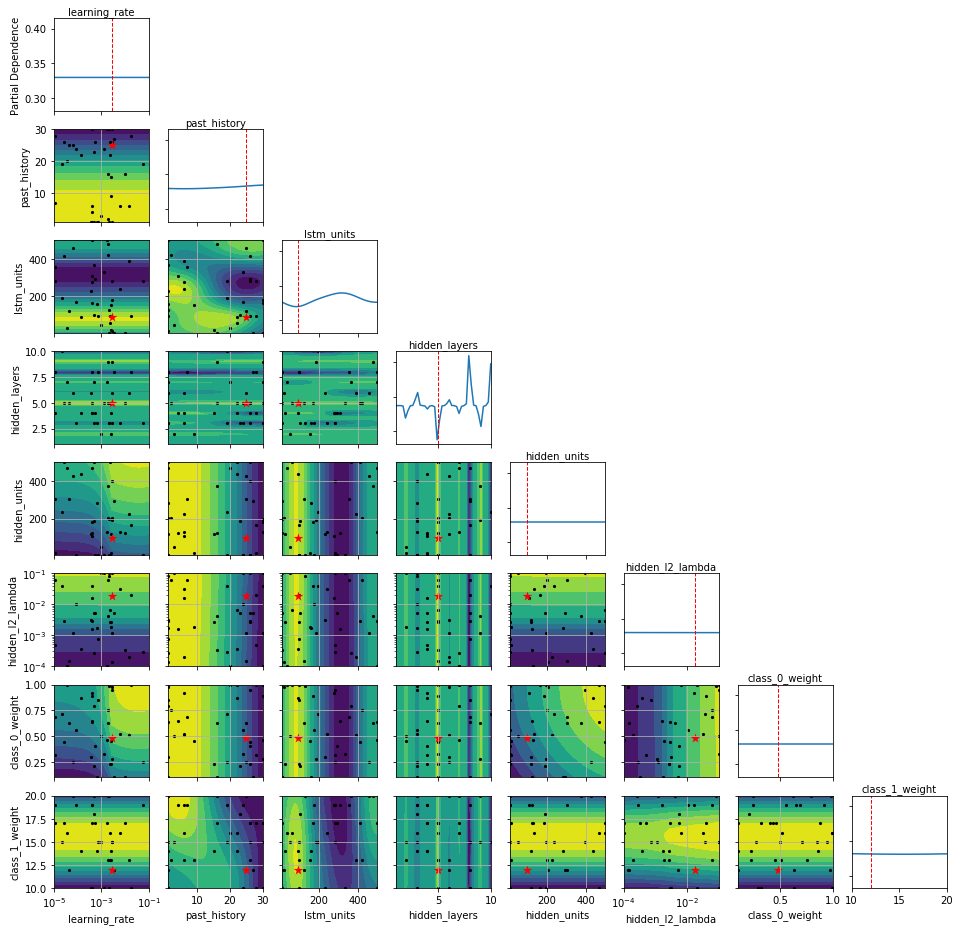

In [19]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

**Try a longer training run with the winning hyperparameters** Some of these, we will manually tweak based on the above graph.

In [20]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.002754143921332031,
 'past_history': 25,
 'lstm_units': 91,
 'hidden_layers': 5,
 'hidden_units': 95,
 'hidden_l2_lambda': 0.01845373292661596,
 'class_0_weight': 0.48264028704212036,
 'class_1_weight': 12}

In [21]:
# learning_rate = 3.4e-02
# past_history = 27
# lstm_units = 193
# hidden_layers = 1
# hidden_units = 87
# #lstm_l2_lambda = 1.1e-03
# hidden_l2_lambda = 3.6e-03
# class_0_weight = 0.1
# class_1_weight = 10

# learning rate: 3.4e-03
# past history: 27
# LSTM units: 193
# hidden layers: 1
# hidden units: 87
# hidden l2 lambda: 3.6e-03
# class 0 weight: 0.1
# class 1 weight: 10

learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
lstm_units = winning_hyperparams['lstm_units']
hidden_layers = winning_hyperparams['hidden_layers']
hidden_units = winning_hyperparams['hidden_units']
#lstm_l2_lambda = winning_hyperparams['lstm_l2_lambda']
hidden_l2_lambda = winning_hyperparams['hidden_l2_lambda']
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']

future_target = 1
step = 1

initial_bias = -1.4
output_bias = tf.keras.initializers.Constant(initial_bias)
    
class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 15
BATCH_SIZE = 100
STEPS_PER_EPOCH = (len(training_data) * 0.5) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 0.5) // BATCH_SIZE

In [22]:
x_train, y_train = multivariate_data(
    training_data, 
    training_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % BATCH_SIZE))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = multivariate_data(
    validation_data, 
    validation_data[:, 1], 
    0,
    None,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % BATCH_SIZE))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

input_dim = x_train.shape[-2:]

input_shape = (BATCH_SIZE, input_dim[0], input_dim[1])

In [23]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    lstm_units,
    batch_input_shape=input_shape,
#         bias_initializer=keras.initializers.VarianceScaling(
#             scale=1.0,
#             mode='fan_in', 
#             distribution='normal', 
#             seed=None
#         ),
#         kernel_regularizer=keras.regularizers.l2(lstm_l2_lambda),
#         activation = 'relu',
     stateful = True
))

for i in range(hidden_layers):
    model.add(keras.layers.Dense(
        hidden_units,
        bias_initializer=keras.initializers.VarianceScaling(
            scale=1.0,
            mode='fan_in', 
            distribution='normal', 
            seed=None
        ),
        kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
        activation = 'relu'
    ))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'softmax',
    bias_initializer = output_bias)
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate), 
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [24]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [early_stopping],
    validation_data=(x_validation, y_validation),
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    workers=8
)

Train on 6300 samples, validate on 2300 samples
Epoch 1/15
3100/6300 [=============>................] - ETA: 2s - loss: 7.0014 - tp: 151.0000 - fp: 2949.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0487 - precision: 0.0487 - recall: 1.0000 - auc: 0.5000 - f1: 0.6188 - val_loss: 3.3792 - val_tp: 44.0000 - val_fp: 1056.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0400 - val_precision: 0.0400 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.4483Epoch 00011: early stopping


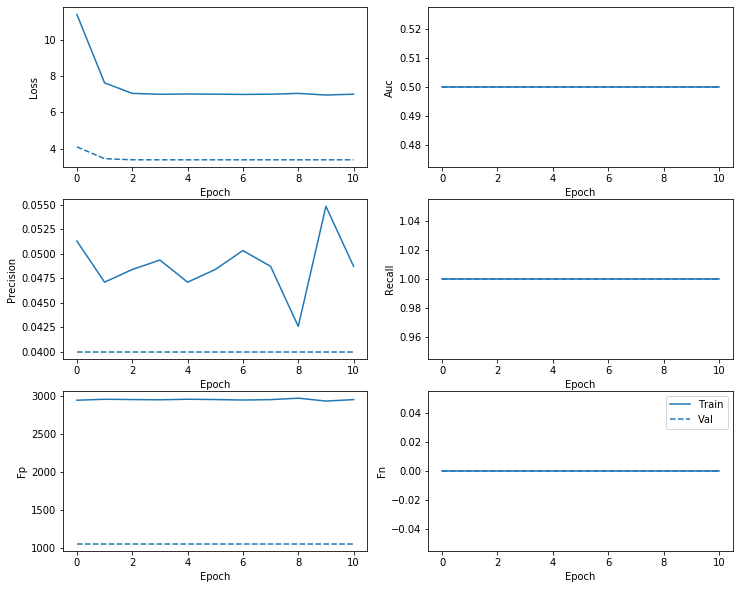

In [25]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_metrics(history)

In [26]:
predictions = model.predict(x_train)

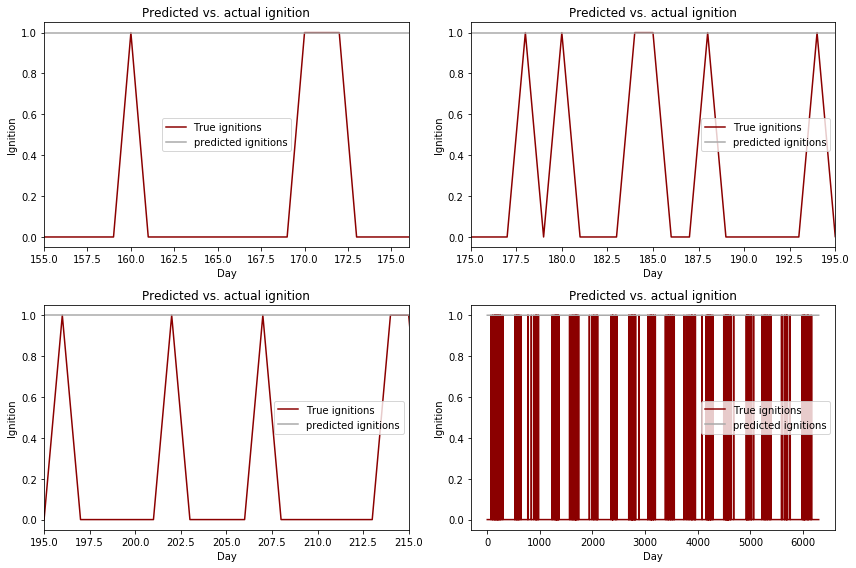

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(2,2,figsize=(12,8))

plt.subplot(2, 2, 1)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(2, 2, 2)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(2, 2, 3)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(2, 2, 4)

plt.plot(
    range(len(y_train)), 
    y_train,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(y_train)), 
    predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
#plt.xlim(195,215)

plt.tight_layout()
plt.show()